<a href="https://colab.research.google.com/github/KillerStrike17/Resnet-with-GradCam-Pyotrch/blob/main/gradcam_output.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/KillerStrike17/DeepLib

fatal: destination path 'DeepLib' already exists and is not an empty directory.


In [2]:
!pip install torch-lr-finder

In [3]:
import torch
import matplotlib.pyplot as plt
torch.autograd.set_detect_anomaly(True)

torch.manual_seed(1)

batch_size = 512
class_map = {
    0:'airplane',
    1:'automobile',
    2:'bird',
    3:'cat',
    4:'deer',
    5:'dog',
    6:'frog',
    7:'horse',
    8:'ship',
    9:'truck'
}
show_summary = True
show_dataset_analyze = True

In [4]:
# Load Network and Print Summary
from DeepLib.DeepLib.model import resnet
from DeepLib.DeepLib.utils import get_device, print_summary

# Check GPU availability
use_cuda, device = get_device()
use_cuda

True

In [5]:
device

device(type='cuda')

In [6]:
from DeepLib.DeepLib.dataset import get_loader
from DeepLib.DeepLib.transform import get_a_train_transform, get_a_test_transform

train_loader, test_loader = get_loader('CIFAR10',get_a_train_transform(), get_a_test_transform(), batch_size=batch_size, use_cuda=use_cuda)

Files already downloaded and verified


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Files already downloaded and verified


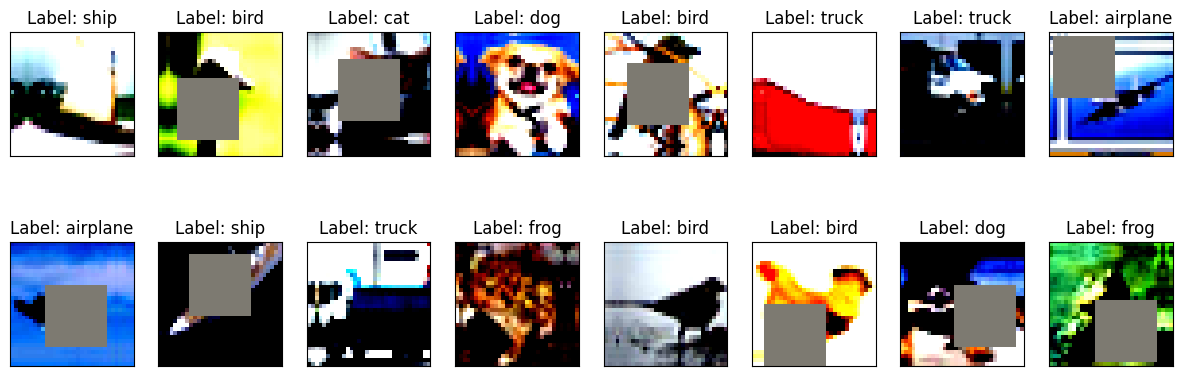

In [7]:
# Calculate Class Scale
from DeepLib.DeepLib.visualize import print_class_scale, print_samples
if show_dataset_analyze:
    # print_class_scale(train_loader, class_map)
    print_samples(train_loader,class_map)#

In [8]:
import time
import math

from DeepLib.DeepLib.backpropagation import train, test, get_sgd_optimizer,get_adam_optimizer
from DeepLib.DeepLib.utils import initialize_weights
from DeepLib.DeepLib.scheduler import one_cycle_lr_pt, one_cycle_lr_custom
from DeepLib.DeepLib.training import Training

# bnmodel = CifarNet(norm='bn',base_channels=12).apply(initialize_weights).to(device)
model = resnet.ResNet18().apply(initialize_weights).to(device)
print_summary(model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14          [-1, 128,

/usr/local/lib/python3.10/dist-packages/torch_lr_finder/lr_finder.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


  0%|          | 0/200 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 4.02E-02


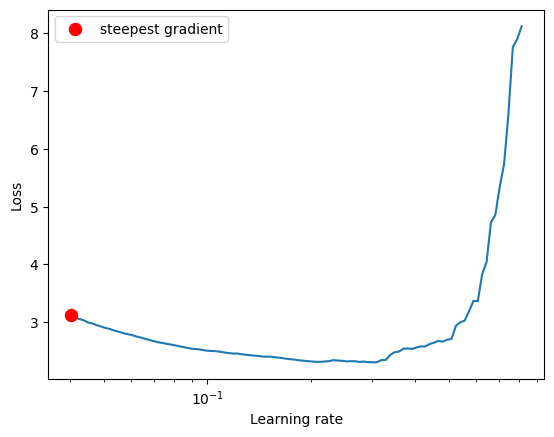

In [9]:
from torch_lr_finder import LRFinder

criterion = torch.nn.CrossEntropyLoss()
optimizer = get_adam_optimizer(model, lr=0.03, weight_decay=1e-4)
lr_finder = LRFinder(model, optimizer, criterion, device="cuda")
lr_finder.range_test(train_loader, end_lr=10, num_iter=200, step_mode = "exp")
lr_finder.plot() # to inspect the loss-learning rate graph
lr_finder.reset() # to reset the model and optimizer to their initial state

In [10]:
# Train Params
epochs = 20
# lr =
max_lr = 4.02E-02
steps_per_epoch = len(train_loader)
dropout = False
momentum = 0.9
weight_decay = 1e-4

print("Using Device:", device)
print("Epochs:", epochs)
# print("Lr:", lr)
print("Max Lr:", max_lr)
print("Batch Size:", batch_size)
print("Dropout:", dropout)
print("\n")

Using Device: cuda
Epochs: 20
Max Lr: 0.0402
Batch Size: 512
Dropout: False




In [11]:
pytorch_scheduler = one_cycle_lr_pt(
    optimizer,
    max_lr=max_lr,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    anneal_strategy='linear'
)

In [12]:
trainer = Training(
    model,
    optimizer,
    pytorch_scheduler,
    train(),
    test,
    train_loader,
    test_loader,
    epochs,
    device,
    dropout
)

trainer.run()

| Epoch | LR       | Time    | TrainLoss | TrainCorrect | TrainAcc | ValLoss  | ValCorrect | ValAcc |
|     1 | 0.000402 | 00m 49s | 1.605436  |        20672 | 41.34  % | 5.696625 |       2632 | 26.32% |
|     2 | 0.008378 | 00m 50s | 1.28708   |        26724 | 53.45  % | 1.217429 |       5722 | 57.22% |
|     3 | 0.016354 | 00m 50s | 1.142303  |        29642 | 59.28  % | 1.216833 |       5513 | 55.13% |
|     4 | 0.024330 | 00m 49s | 1.066018  |        31121 | 62.24  % | 1.276567 |       5692 | 56.92% |
|     5 | 0.032306 | 00m 49s | 1.065436  |        31194 | 62.39  % | 1.281663 |       5488 | 54.88% |
|     6 | 0.040173 | 00m 49s | 1.019849  |        32011 | 64.02  % | 1.128887 |       5982 | 59.82% |
|     7 | 0.037493 | 00m 49s | 0.970958  |        32841 | 65.68  % | 0.997917 |       6511 | 65.11% |
|     8 | 0.034813 | 00m 48s | 0.935075  |        33509 | 67.02  % | 2.318555 |       4367 | 43.67% |
|     9 | 0.032133 | 00m 49s | 0.899881  |        34132 | 68.26  % | 1.414384 |   

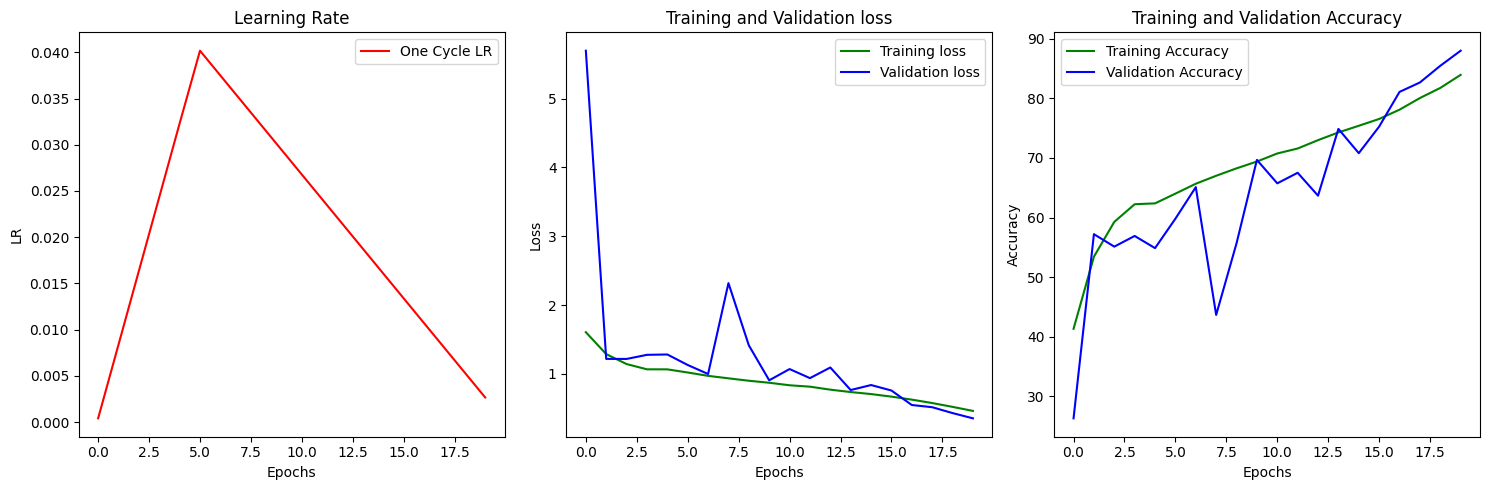

Confusion matrix, without normalization


Total Incorrect Predictions 1200


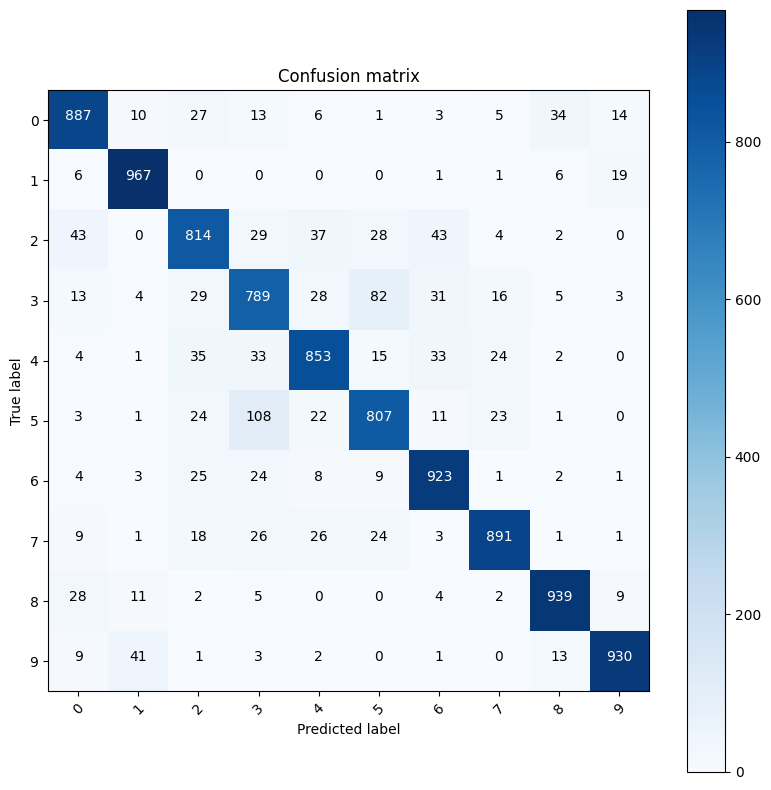

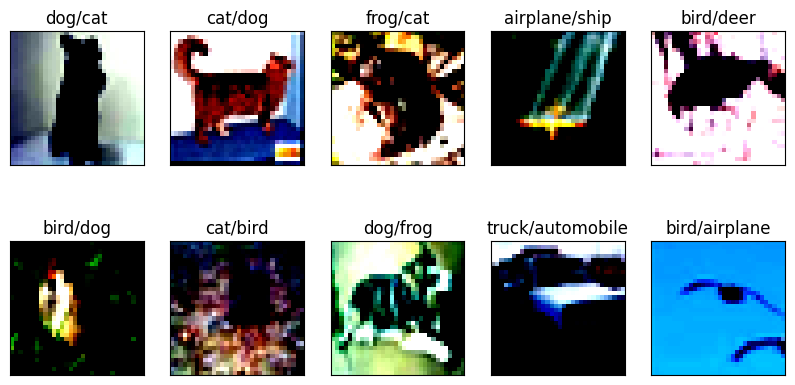

In [13]:
from DeepLib.DeepLib.visualize import plot_network_performance

# trainer.print_best_model()
plot_network_performance(epochs, trainer.schedule, trainer.list_train_loss, trainer.list_valid_loss, trainer.list_train_correct, trainer.list_valid_correct)

from DeepLib.DeepLib.utils import get_all_predictions, get_incorrrect_predictions, prepare_confusion_matrix
from DeepLib.DeepLib.visualize import plot_confusion_matrix

all_preds, all_targets = get_all_predictions(model, test_loader, device)
confusion_matrix = prepare_confusion_matrix(all_preds, all_targets, class_map)
plot_confusion_matrix(confusion_matrix, class_map, False)


from DeepLib.DeepLib.utils import get_incorrrect_predictions
from DeepLib.DeepLib.visualize import plot_incorrect_predictions

incorrect = get_incorrrect_predictions(model, test_loader, device)
plot_incorrect_predictions(incorrect, class_map)

In [14]:
target_layers = [model.layer3[-1]]

In [15]:
model.load_state_dict(torch.load("myweights"))
model.to(device)
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=

In [16]:
test(model.float(),test_loader,"cuda")

(0.339216187286377, 8863)

In [17]:
use_cuda

True

In [18]:
from DeepLib.DeepLib.dataset import get_loader
from DeepLib.DeepLib.transform import get_p_train_transform, get_p_test_transform

train_loader, test_loader = get_loader('CIFAR10',get_p_train_transform(), get_p_test_transform(), batch_size=20, use_cuda=use_cuda)

here
Files already downloaded and verified
Files already downloaded and verified


In [19]:
# for img, label in test_loader:
#   print(img)
#   break

In [20]:
# test_loader.items()

In [21]:
  # input_tensor = next(iter(test_loader))
  !pip install grad-cam

In [22]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image

Image Shape: torch.Size([3, 32, 32])


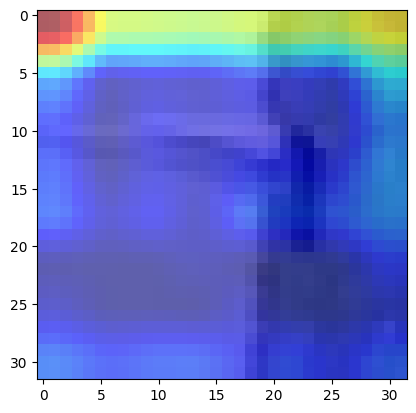

Image Shape: torch.Size([3, 32, 32])


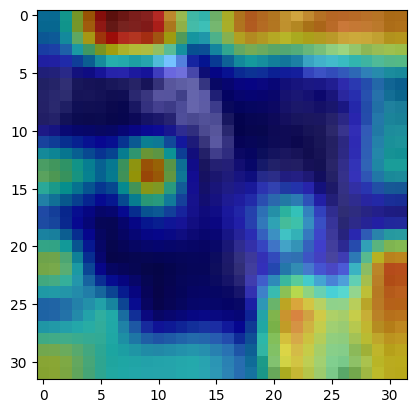

Image Shape: torch.Size([3, 32, 32])


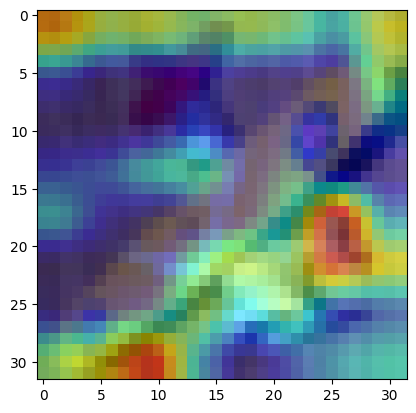

Image Shape: torch.Size([3, 32, 32])


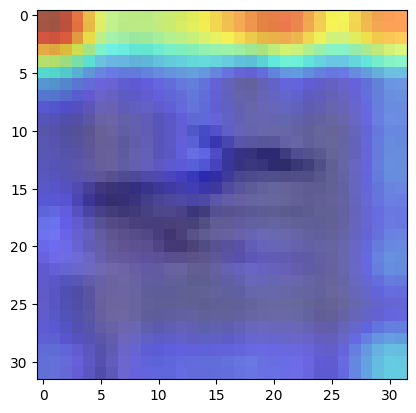

Image Shape: torch.Size([3, 32, 32])


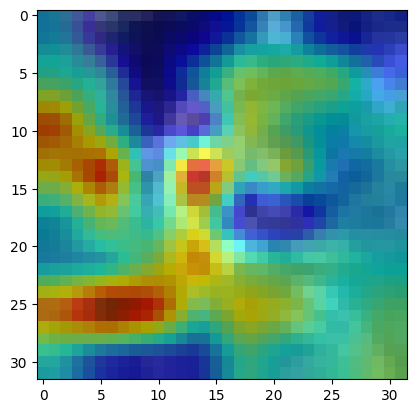

Image Shape: torch.Size([3, 32, 32])


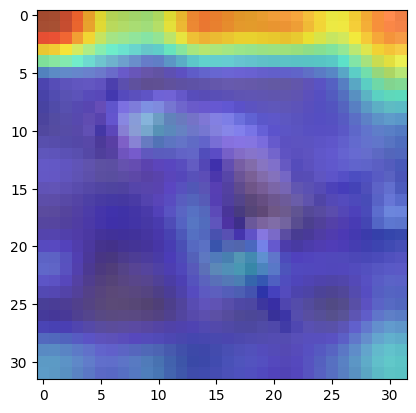

Image Shape: torch.Size([3, 32, 32])


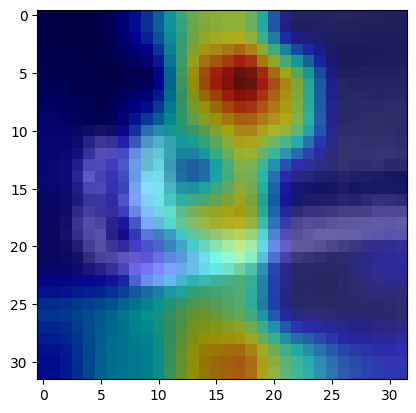

Image Shape: torch.Size([3, 32, 32])


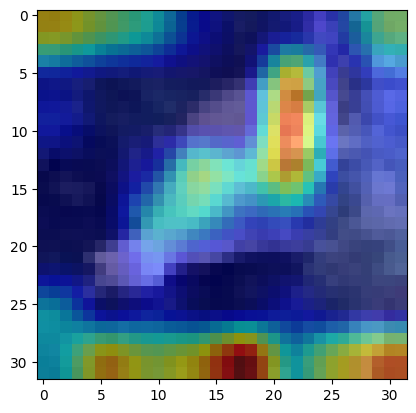

Image Shape: torch.Size([3, 32, 32])


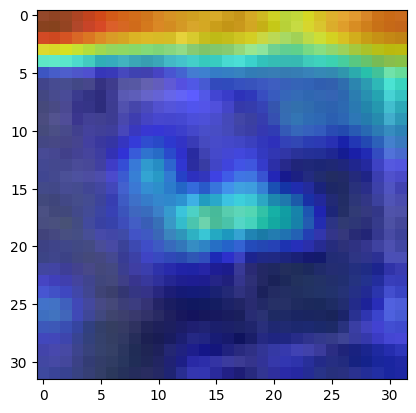

Image Shape: torch.Size([3, 32, 32])


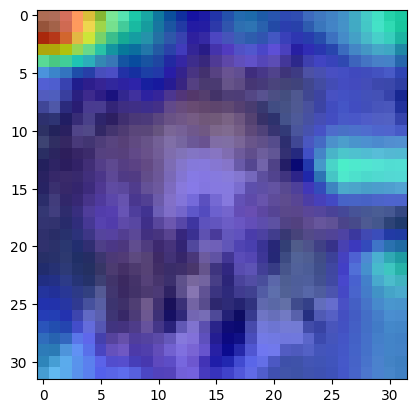

Image Shape: torch.Size([3, 32, 32])


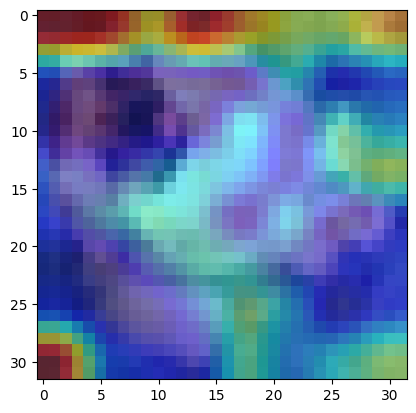

Image Shape: torch.Size([3, 32, 32])


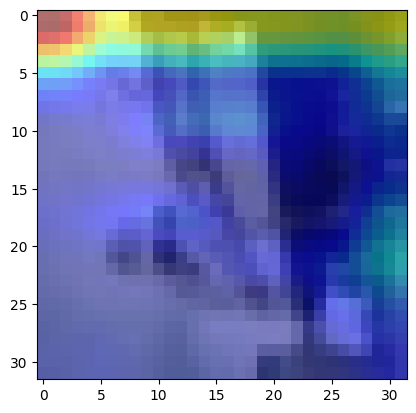

Image Shape: torch.Size([3, 32, 32])


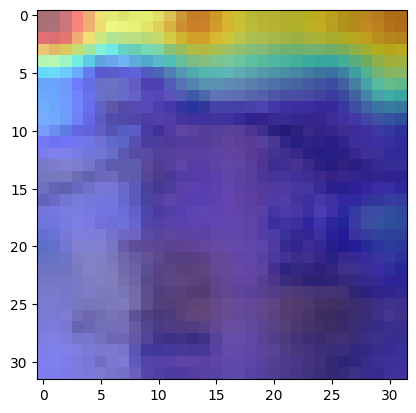

Image Shape: torch.Size([3, 32, 32])


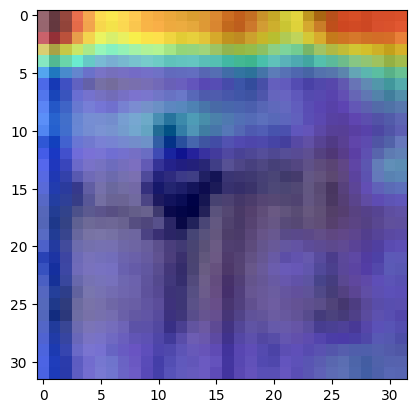

Image Shape: torch.Size([3, 32, 32])


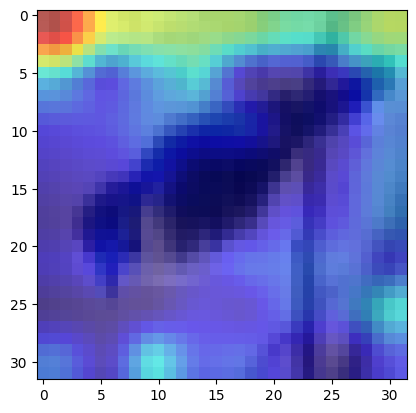

Image Shape: torch.Size([3, 32, 32])


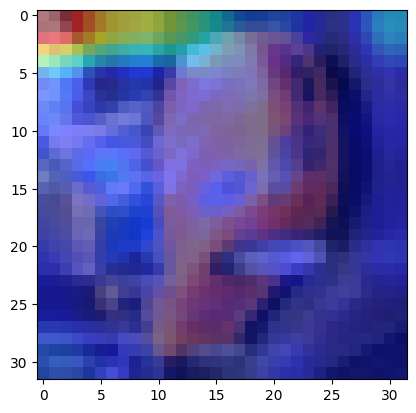

Image Shape: torch.Size([3, 32, 32])


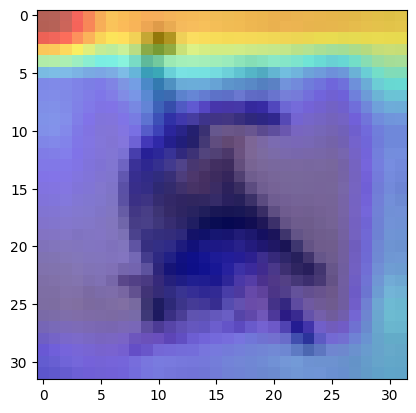

Image Shape: torch.Size([3, 32, 32])


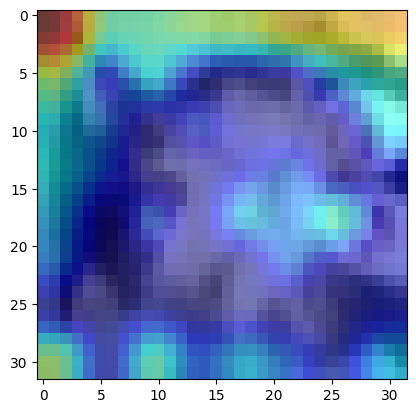

Image Shape: torch.Size([3, 32, 32])


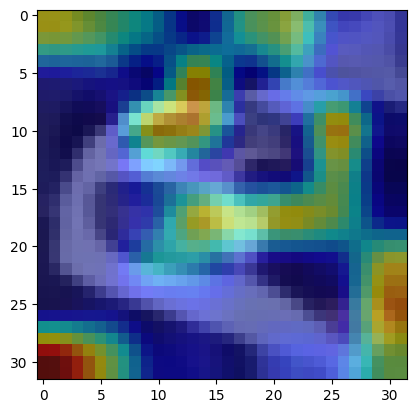

Image Shape: torch.Size([3, 32, 32])


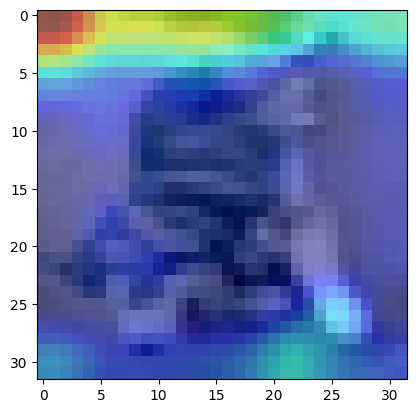

In [23]:
test_batch = next(iter(test_loader))
counter = 0
cam = GradCAM(model=model, target_layers=target_layers, use_cuda=use_cuda)
grayscale_cam = cam(input_tensor=test_batch[0].float())
for image in test_batch[0]:
  print("Image Shape:",image.shape)
  temp = grayscale_cam[counter, :]
  visualization = show_cam_on_image((image.float()/255).numpy().transpose(2,1,0), temp, use_rgb=True)
  plt.imshow(visualization)
  plt.show()
  counter +=1

In [24]:
import zipfile
import os

def zip_folder(folder_path, output_path):
    # Ensure the folder exists
    if not os.path.exists(folder_path):
        print(f"Error: Folder '{folder_path}' does not exist.")
        return

    # Create a ZipFile object with the output file path
    with zipfile.ZipFile(output_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
        # Walk through all the files and subdirectories in the folder
        for root, _, files in os.walk(folder_path):
            for file in files:
                # Get the full path of the file
                file_path = os.path.join(root, file)
                # Get the relative path inside the ZIP archive by removing the folder_path prefix
                zip_path = os.path.relpath(file_path, folder_path)
                # Add the file to the ZIP archive
                zipf.write(file_path, zip_path)

    print(f"Folder '{folder_path}' zipped successfully to '{output_path}'.")

In [25]:
# Example usage:
folder_to_zip = "/content/DeepLib/DeepLib"
output_zip_file = "deeplib.zip"

zip_folder(folder_to_zip, output_zip_file)

Folder '/content/DeepLib/DeepLib' zipped successfully to 'deeplib.zip'.
